# Analysis of Motion Sickness and Embodiment Data

Author: Zora Nolte

Last updated: 17.02.2022

In [42]:
import os
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np
from scipy import stats

In [43]:
# load the data
search_path = os.getcwd() + '\\data\\' # location of the data files
df = pd.read_csv(search_path + "data_questionnaires_preprocessed.csv", converters={'BE04_01':str, 'BE04_02':str, 'BE04_03':str})
df = df.rename(columns={"blob" : 'condition'})

In [44]:
sig_level = 0.05 # p value to be used as threshold

## Notes on Mixed ANOVA

**Independent variables:** two categorical independent variables (factors)
- one of which is between-subject (each subjects assigned only once to treatment): blob vs. avatar
- the other is within-subject (each subject assigned multiple treatments): hybrid vs. first-person

**Assumptions:**
- The responses from subjects (dependent variable) should be continuous
- Residuals (experimental error) are approximately normally distributed for each combination of between-subject and within-subject variable (Shapiro-Wilks Test or histogram)
- Homogeneity of variances or homoscedasticity: There should be equal variance for every level of within-subject factor (Levene’s test)
- Assumption of sphericity: the variances of differences in responses between any two levels of the independent variable (within-subjects factor) should be equal (Mauchly’s test of sphericity). This assumptionn is also known as homogeneity-of-variance-of-differences assumption.
- Homogeneity of the variance-covariance matrices: the pattern of intercorrelation for each level of within-subject variable across between-subject variable should be equal. This is a multivariate version of the Homogeneity of variances. It can be tested using Box’s M test. Box’s M-test has little power and uses a lower alpha level such as 0.001 to assess the p value for significance.
- There should be no significant outlier (this can be checked by boxplot)
 
**Results:**
- Two-way mixed ANOVA estimates the three effects - two main effects and one interaction effect - for statistical significance
- Generally, it is not appropriate to interpret main effects when interaction is significant.

(Source: https://www.reneshbedre.com/blog/mixed-anova.html)


## Naming conventions

- condition: blob vs. avatar (1: blob, 0: avatar)
- mode: first-person vs. hybrid

## Important Note

**p-values are not corrected for multiple analyses in this notebook!**

## Functions

In [45]:
def summarize(df, var):
    '''
    Groups the df by the independent factors, and prints the variable's count, mean, and std.
    
    df (pd.DataFrame)
    var (str): the column to summarize
    '''
    return df.groupby(["condition", "mode"]).describe()[var][["count", "mean", "std"]]

In [46]:
def boxplot(df, var, title, ax, legend=True):
    '''
    Creates a boxplot of the variable, separated by condition and mode.
    
    df (pd.DataFrame)
    var (str): the column to plot
    title (str): title of the boxplot
    ax (plt.axis): ax to be plotted on
    
    '''
    my_palette = sns.color_palette([sns.color_palette("tab10")[1], sns.color_palette("tab10")[0]])
    
    sns.boxplot(x='condition', y=var, hue='mode', data=df, ax=ax,
                showmeans=True, meanprops={"marker":"d","markerfacecolor":"white", "markeredgecolor":"black"},
                palette=my_palette)
    ax.set_title(title, fontsize=18)
    if legend:
        ax.legend(title="Viewing Mode", fontsize=13, title_fontsize=13, loc='upper left', bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()
    
    ax.xaxis.label.set_size(16)
    ax.xaxis.labelpad = 10
    ax.yaxis.label.set_size(16)
    ax.yaxis.labelpad = 10
    ax.tick_params(axis='both', which='major', labelsize=14)
    sns.despine()


In [47]:
def interact_plot(df, var, title, ax):
    '''
    Plots the interaction of condition and mode for the variable.
    
    df (pd.DataFrame)
    var (str):  dependent variable column name
    title (str): title of the plot
    '''
    interaction_plot(x=df['condition'], trace=df['mode'], response=df[var], ax=ax,
                     colors=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[1]], 
                     markers=['D','^'])
    ax.set_title(title, fontsize=18)
    ax.legend(title="Viewing Mode", fontsize=13, title_fontsize=13, loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylabel("Mean")
    ax.set_xlabel("Condition")
    
    ax.xaxis.label.set_size(16)
    ax.xaxis.labelpad = 10
    ax.yaxis.label.set_size(16)
    ax.yaxis.labelpad = 10
    ax.tick_params(axis='both', which='major', labelsize=14)
 
    sns.despine()
    plt.show()

In [48]:
def check_assumptions(df, dv, dv_name):
    '''
    Checks the assumptions of a mixed ANOVA.
    
    df (pd.DataFrame)
    dv (str): dependent variable column name
    dv_name (str): name of the dependent variable (to be printed)
    '''
    
    print("Checking the assumptions for the dependent variable {}...\n".format(dv_name))
    all_assumptions = []
    
    # Assumption of the residuals being normally distributed
    df['factor_comb'] = df["condition"] + '-'+ df["mode"]
    normal = pg.normality(data=df, dv=dv, group='factor_comb')
    if normal["normal"].all():
        print("The residuals are approximately normally distributed for each level of the within-subjects factor (tested using the Shapiro-Wilks Test)")
        all_assumptions.append(True)
    else:
        print("The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)")
        all_assumptions.append(False)
    
    print()
    # Assumption of homoscedasticity
    print("There should be equal variance for every level of within-subject factor:")
    hybrid = df[df["mode"]=="Hybrid"].reset_index(drop=True)
    homo_hybrid = pg.homoscedasticity(data=hybrid, dv=dv, group='condition')
    all_assumptions.append(homo_hybrid["equal_var"][0])
    print("For the level Hybrid, Levene's test resulted in a p-value of {}, indicating that the assumption of equal variances is {}.".format(homo_hybrid["pval"][0].round(3), homo_hybrid["equal_var"][0]))
    
    fp = df[df["mode"]=="First Person"].reset_index(drop=True)
    homo_fp = pg.homoscedasticity(data=fp, dv=dv, group='condition')
    all_assumptions.append(homo_fp["equal_var"][0])
    print("For the level First Person, Levene's test resulted in a p-value of {}, indicating that the assumption of equal variances is {}.".format(homo_fp["pval"][0].round(3), homo_fp["equal_var"][0]))
    
    print()    
    # Assumption of sphericity
    sphericity = pg.sphericity(data=df, dv=dv, subject='ID', within='condition')
    all_assumptions.append(sphericity[0])
    print("Mauchly’s test of sphericity resulted in a p-value of {}, indicating that the assumption is {}.".format(sphericity[-1], sphericity[0]))
    
    print()
    # Assumption of homogeneity of the variance-covariance matrices:
    print("The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:")
    box_fp = pg.box_m(data=fp, dvs=[dv], group='condition', alpha=0.001)
    all_assumptions.append(box_fp["equal_cov"][0])    
    print("For the level First Person, Box’s M test resulted in a p-value of {}, indicating that the assumption is {}.".format(box_fp["pval"][0].round(3), box_fp["equal_cov"][0]))
    
    box_hybrid = pg.box_m(data=hybrid, dvs=[dv], group='condition', alpha=0.001)
    all_assumptions.append(box_hybrid["equal_cov"][0])    
    print("For the level Hybrid, Box’s M test resulted in a p-value of {}, indicating that the assumption is {}.".format(box_hybrid["pval"][0].round(3), box_hybrid["equal_cov"][0]))

    print()
    # Assumption of no outliers
    outliers = df[df[dv] > df[dv].mean() + 3 * df[dv].std()]
    print("A data point is called an outlier if it > 3 sd away from the mean.")
    if outliers.empty:
        print("There are no outliers!")
        all_assumptions.append(True)
    else: 
        print("There are outliers! The outliers are the participants {}".format(outliers["ID"].values))
        all_assumptions.append(False)
    
    
    if all(x == True for x in all_assumptions):
        print()
        print("ALL ASSUMPTIONS ARE TRUE!")

# Motion Sickness

## Effect of condition and mode on in-game MS ratings (total score)

In [49]:
ms = pd.melt(df.reset_index(), id_vars=['ID', 'condition'], value_vars=['H_AVG_MS', 'FP_AVG_MS'])
ms = ms.rename(columns={"variable" : 'mode', "value" : "rating"})
ms.replace({'mode': {'H_AVG_MS': 'Hybrid', 'FP_AVG_MS': 'First Person'},
               'condition': {1: 'Blob', 0: 'Avatar'}}, inplace=True)

ms_anova = pg.mixed_anova(dv='rating', between='condition', within='mode', subject='ID', data=ms)
ms_anova

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,1.670385,1,81,1.670385,1.401606,0.239918,0.017009,NaN
1,mode,3.947952,1,81,3.947952,10.232417,0.001970,0.112158,1.0
2,Interaction,0.719990,1,81,0.719990,1.866091,0.175704,0.022519,NaN


In [50]:
summarize(ms, "rating")

count      mean       std
condition mode                                   
Avatar    First Person   43.0  0.767442  0.786711
          Hybrid         43.0  0.586047  0.748834
Blob      First Person   40.0  1.100000  1.168826
          Hybrid         40.0  0.655000  0.799984

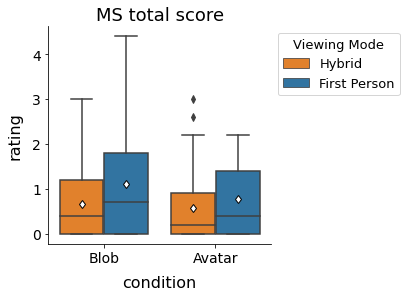

In [51]:
fig, ax = plt.subplots(figsize=(4,4))
boxplot(ms, "rating", "MS total score", ax)

In [52]:
# if interaction is significant, create interaction plot
if ms_anova["p-unc"].tolist()[-1] < sig_level:
    fig, ax = plt.subplots(figsize=(4,4))
    interact_plot(ms, "rating", "MS Total Score", ax=ax)

## Effect of condition and mode on in-game MS ratings (per area)

### Area 1

In [53]:
area_one = pd.melt(df.reset_index(), id_vars=['ID', 'condition'], value_vars=['H_1_MS', 'FP_1_MS'])
area_one = area_one.rename(columns={"variable" : 'mode', "value" : "rating"})
area_one.replace({'mode': {'H_1_MS': 'Hybrid', 'FP_1_MS': 'First Person'},
               'condition': {1: 'Blob', 0: 'Avatar'}}, inplace=True)

area_one_anova = pg.mixed_anova(dv='rating', between='condition', within='mode', subject='ID', data=area_one)
area_one_anova

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,0.958003,1,81,0.958003,0.507798,0.478141,0.006230,NaN
1,mode,6.560241,1,81,6.560241,8.666658,0.004228,0.096654,1.0
2,Interaction,0.626678,1,81,0.626678,0.827897,0.365581,0.010118,NaN


In [54]:
summarize(area_one, "rating")

count     mean       std
condition mode                                  
Avatar    First Person   43.0  1.00000  1.133893
          Hybrid         43.0  0.72093  0.934156
Blob      First Person   40.0  1.27500  1.432006
          Hybrid         40.0  0.75000  1.056118

In [55]:
# if interaction is significant, create interaction plot
if area_one_anova["p-unc"].tolist()[-1] < sig_level:
    fig, ax = plt.subplots(figsize=(4,4))
    interact_plot(area_one, "rating", "Interaction Condition x Mode (Area 1)", ax=ax)

### Area 2

In [56]:
area_two = pd.melt(df.reset_index(), id_vars=['ID', 'condition'], value_vars=['H_2_MS', 'FP_2_MS'])
area_two = area_two.rename(columns={"variable" : 'mode', "value" : "rating"})
area_two.replace({'mode': {'H_2_MS': 'Hybrid', 'FP_2_MS': 'First Person'},
               'condition': {1: 'Blob', 0: 'Avatar'}}, inplace=True)

area_two_anova = pg.mixed_anova(dv='rating', between='condition', within='mode', subject='ID', data=area_two)
area_two_anova

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,2.372265,1,81,2.372265,1.615536,0.207353,0.019555,NaN
1,mode,4.072289,1,81,4.072289,4.129600,0.045417,0.048510,1.0
2,Interaction,5.051839,1,81,5.051839,5.122935,0.026287,0.059484,NaN


In [57]:
summarize(area_two, "rating")

count      mean       std
condition mode                                   
Avatar    First Person   43.0  0.511628  0.855573
          Hybrid         43.0  0.534884  1.008271
Blob      First Person   40.0  1.100000  1.629850
          Hybrid         40.0  0.425000  0.747217

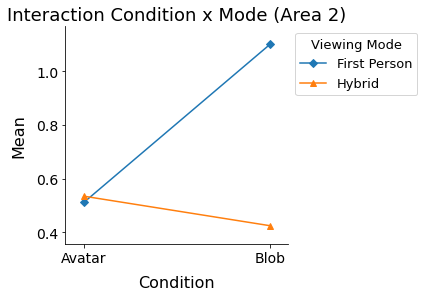

In [58]:
# if interaction is significant, create interaction plot
if area_two_anova["p-unc"].tolist()[-1] < sig_level:
    fig, ax = plt.subplots(figsize=(4,4))
    interact_plot(area_two, "rating", "Interaction Condition x Mode (Area 2)", ax=ax)

### Area 3

In [59]:
area_three = pd.melt(df.reset_index(), id_vars=['ID', 'condition'], value_vars=['H_3_MS', 'FP_3_MS'])
area_three = area_three.rename(columns={"variable" : 'mode', "value" : "rating"})
area_three.replace({'mode': {'H_3_MS': 'Hybrid', 'FP_3_MS': 'First Person'},
               'condition': {1: 'Blob', 0: 'Avatar'}}, inplace=True)

area_three_anova = pg.mixed_anova(dv='rating', between='condition', within='mode', subject='ID', data=area_three)
area_three_anova

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,0.535448,1,81,0.535448,0.316758,0.575117,0.003895,NaN
1,mode,4.072289,1,81,4.072289,6.232815,0.014568,0.071450,1.0
2,Interaction,0.005327,1,81,0.005327,0.008153,0.928275,0.000101,NaN


In [60]:
summarize(area_three, "rating")

count      mean       std
condition mode                                   
Avatar    First Person   43.0  1.000000  1.214986
          Hybrid         43.0  0.697674  0.939475
Blob      First Person   40.0  1.125000  1.113726
          Hybrid         40.0  0.800000  1.042679

In [61]:
# if interaction is significant, create interaction plot
if area_three_anova["p-unc"].tolist()[-1] < sig_level:
    fig, ax = plt.subplots(figsize=(4,4))
    interact_plot(area_three, "rating", "Interaction Condition x Mode (Area 3)", ax=ax)

### Area 4

In [62]:
area_four = pd.melt(df.reset_index(), id_vars=['ID', 'condition'], value_vars=['H_4_MS', 'FP_4_MS'])
area_four = area_four.rename(columns={"variable" : 'mode', "value" : "rating"})
area_four.replace({'mode': {'H_4_MS': 'Hybrid', 'FP_4_MS': 'First Person'},
               'condition': {1: 'Blob', 0: 'Avatar'}}, inplace=True)

area_four_anova = pg.mixed_anova(dv='rating', between='condition', within='mode', subject='ID', data=area_four)
area_four_anova

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,6.757218,1,81,6.757218,2.414094,0.124146,0.028941,NaN
1,mode,6.560241,1,81,6.560241,6.817513,0.010753,0.077633,1.0
2,Interaction,1.996445,1,81,1.996445,2.074739,0.153610,0.024974,NaN


In [63]:
summarize(area_four, "rating")

count      mean       std
condition mode                                   
Avatar    First Person   43.0  0.976744  1.204918
          Hybrid         43.0  0.790698  1.081404
Blob      First Person   40.0  1.600000  1.891953
          Hybrid         40.0  0.975000  1.187272

In [64]:
# if interaction is significant, create interaction plot
if area_four_anova["p-unc"].tolist()[-1] < sig_level:
    fig, ax = plt.subplots(figsize=(4,4))
    interact_plot(area_four, "rating", "Interaction Condition x Mode (Area 4)", ax=ax)

### Plot ratings for each area

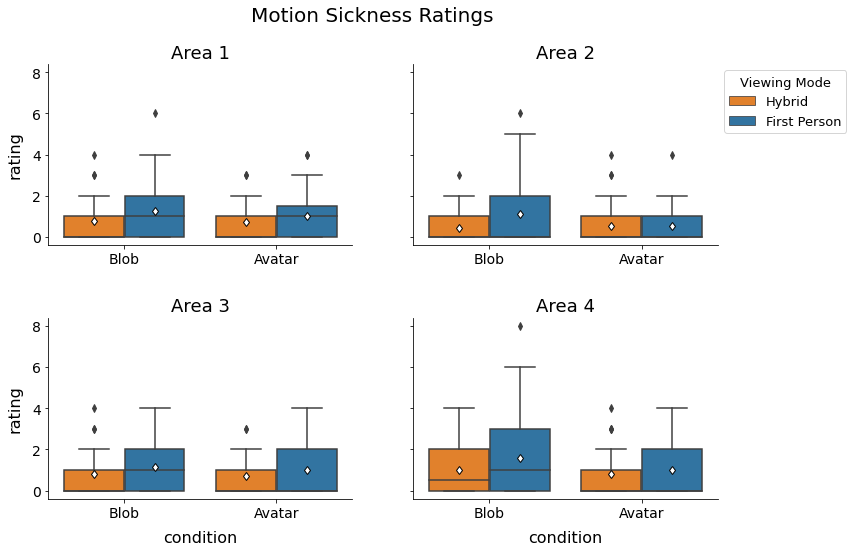

In [65]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
plt.subplots_adjust(hspace=0.4)
fig.suptitle('Motion Sickness Ratings', fontsize=20)

ax = ax.ravel()

boxplot(area_one, "rating", "Area 1", ax[0], legend=False)
boxplot(area_two, "rating", "Area 2", ax[1])
boxplot(area_three, "rating", "Area 3", ax[2], legend=False)
boxplot(area_four, "rating", "Area 4", ax[3], legend=False)

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[3].set_ylabel("")

plt.draw()

## Simulator Sickness

Subscales:
- Oculomotor (O)
- Disorientation (D)
- Nausea (N)

## Effect of condition and mode on SSQ (total score)

In [66]:
ssq = pd.melt(df.reset_index(), id_vars=['ID', 'condition'], value_vars=['SSQ_TS_H', 'SSQ_TS_FP'])
ssq = ssq.rename(columns={"variable" : 'mode', "value" : "score"})
ssq.replace({'mode': {'SSQ_TS_H': 'Hybrid', 'SSQ_TS_FP': 'First Person'},
               'condition': {1: 'Blob', 0: 'Avatar'}}, inplace=True)

ssq_anova = pg.mixed_anova(dv='score', between='condition', within='mode', subject='ID', data=ssq)
ssq_anova

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,285971.177296,1,81,285971.177296,2.693139,0.104659,0.032179,NaN
1,mode,360262.097586,1,81,360262.097586,17.240210,0.000081,0.175490,1.0
2,Interaction,69847.202687,1,81,69847.202687,3.342512,0.071193,0.039630,NaN


In [67]:
summarize(ssq, "score")

count        mean         std
condition mode                                       
Avatar    First Person   43.0  292.368847  215.622696
          Hybrid         43.0  238.765079  203.249333
Blob      First Person   40.0  416.486400  326.581386
          Hybrid         40.0  280.778630  250.451476

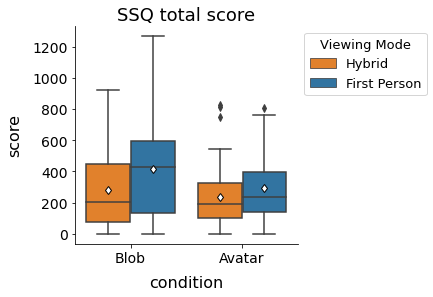

In [68]:
fig, ax = plt.subplots(figsize=(4,4))
boxplot(ssq, "score", "SSQ total score", ax)

In [69]:
# if interaction is significant, create interaction plot
if ssq_anova["p-unc"].tolist()[-1] < sig_level:
    fig, ax = plt.subplots(figsize=(4,4))
    interact_plot(ssq, "score", "Interaction Condition x Mode (SSQ Total Score)", ax=ax)

## Assumption Check Motion Sickness

In [70]:
check_assumptions(ms, 'rating', "MS Total Score")

Checking the assumptions for the dependent variable MS Total Score...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.499, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.071, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.013, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.676, indicating that the assumpt

In [71]:
check_assumptions(area_one, 'rating', "MS ratings Area 1")

Checking the assumptions for the dependent variable MS ratings Area 1...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.894, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.342, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.141, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.438, indicating that the assu

In [72]:
check_assumptions(area_two, 'rating', "MS ratings Area 2")

Checking the assumptions for the dependent variable MS ratings Area 2...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.577, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.041, indicating that the assumption of equal variances is False.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.0, indicating that the assumption is False.
For the level Hybrid, Box’s M test resulted in a p-value of 0.061, indicating that the assu

In [73]:
check_assumptions(area_three, 'rating', "MS ratings Area 3")

Checking the assumptions for the dependent variable MS ratings Area 3...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.639, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.569, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.583, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.51, indicating that the assum

In [74]:
check_assumptions(area_four, 'rating', "MS ratings Area 4")

Checking the assumptions for the dependent variable MS ratings Area 4...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.386, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.094, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.005, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.555, indicating that the assu

In [75]:
check_assumptions(ssq, 'score', "SSQ Total Score")

Checking the assumptions for the dependent variable SSQ Total Score...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.134, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.009, indicating that the assumption of equal variances is False.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.009, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.187, indicating that the assum

## Correlations of the motion sickness variables

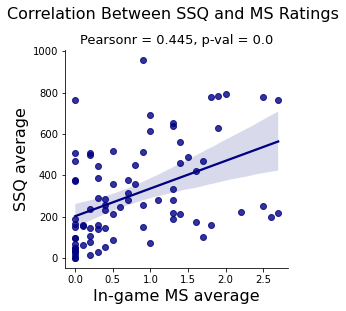

Effect size according to Cohen: medium


In [76]:
## THIS IS ALSO IN THE QUESTIONNAIRE DATA/ PLOTS NB
fig, ax = plt.subplots(figsize=(4,4))
x = df[["H_AVG_MS", "FP_AVG_MS"]].mean(axis=1)
y = df["SSQ_TS_AVG"]
corr = stats.pearsonr(x, y)
sns.regplot(x=x, y=y, ax=ax, marker='o', color='navy')

fig.suptitle("Correlation Between SSQ and MS Ratings", fontsize=16, y=1.03)
ax.set_title("Pearsonr = {}, p-val = {}".format(corr[0].round(3), corr[1].round(3)), fontsize=13)
ax.set_ylabel("SSQ average",fontsize=16)
ax.set_xlabel("In-game MS average",fontsize=16)

sns.despine()
plt.show()

eff = None
if 0.1 <= corr[0] <= 0.3:
    eff = "small"
elif 0.3 < corr[0] <= 0.5:
    eff = "medium"
elif 0.5 < corr[0] <= 1.0:
    eff = "large"

if eff is not None:
    print("Effect size according to Cohen: " + eff)

# Embodiment

Subscales
- Spatial Presence (SP)
 - environmental location (EL)
 - possible actions (PA)
- Embodiment (EB)
 - self-location (SL)
 - agency (A)
 - ownership (O)
 
-> We're only interested in the embodiment part

## Effect of condition and mode on EB (total score)

In [77]:
eb = pd.melt(df.reset_index(), id_vars=['ID', 'condition'], value_vars=['EB_EB_H', 'EB_EB_FP'])
eb = eb.rename(columns={"variable" : 'mode', "value" : "score"})
eb.replace({'mode': {'EB_EB_H': 'Hybrid', 'EB_EB_FP': 'First Person'},
               'condition': {1: 'Blob', 0: 'Avatar'}}, inplace=True)

eb_anova = pg.mixed_anova(dv='score', between='condition', within='mode', subject='ID', data=eb)
eb_anova

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,1.800536,1,81,1.800536,0.051285,0.821413,0.000633,NaN
1,mode,3.765060,1,81,3.765060,0.329506,0.567541,0.004051,1.0
2,Interaction,26.198603,1,81,26.198603,2.292818,0.133866,0.027527,NaN


In [78]:
summarize(eb, "score")

count       mean       std
condition mode                                    
Avatar    First Person   43.0  26.953488  5.424607
          Hybrid         43.0  26.488372  4.500646
Blob      First Person   40.0  25.950000  4.882990
          Hybrid         40.0  27.075000  4.393395

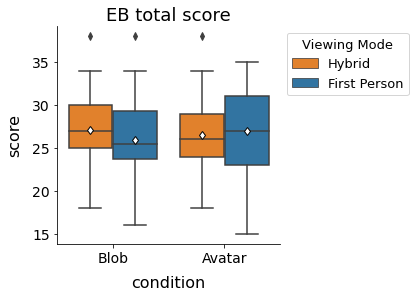

In [79]:
fig, ax = plt.subplots(figsize=(4,4))
boxplot(eb, "score", "EB total score", ax)

In [80]:
# if interaction is significant, create interaction plot
if eb_anova["p-unc"].tolist()[-1] < sig_level:
    fig, ax = plt.subplots(figsize=(4,4))
    interact_plot(eb, "score", "Interaction Condition x Mode (on EB total score)", ax=ax)

## Assumption Check Embodiment

In [81]:
check_assumptions(eb, 'score', "EB Total Score")

Checking the assumptions for the dependent variable EB Total Score...

The residuals are approximately normally distributed for each level of the within-subjects factor (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.764, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.211, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.507, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.879, indicating that the assumption i